In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import import_ipynb
from sklearn import metrics
from sklearn.metrics import accuracy_score, silhouette_score, davies_bouldin_score, mean_squared_error, calinski_harabasz_score
import gnn

Implementing DBSCAN algorithm

In [26]:
gnn.model.eval()
embeddings = []
for data in gnn.test_loader:
    data = data.to(gnn.device)
    emb = gnn.model(data.x, data.edge_index).detach().cpu().numpy()
    embeddings.append(emb)

embeddings = np.concatenate(embeddings, axis=0)

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings)
print(dbscan)

DBSCAN()


if your num_clusters is 0, it likely means that DBSCAN did not find any clusters. This could happen for several reasons:

Epsilon Value Too Small: If the eps parameter is too small, the algorithm may not find any points within the specified distance, resulting in all points being considered as noise. Try increasing the eps value.
MinSamples Too High: If the min_samples parameter is too high, the algorithm might require more points than are present in your data to form a cluster. Lowering this value might help.
Data Scale: If your data is not scaled properly, the distance calculations might not work as expected. Make sure your data is normalized or scaled appropriately.
Data Distribution: Your data might not have enough density to form clusters with the given parameters. In such cases, try adjusting eps and min_samples based on the data distribution.
Data Shape: If your data is too sparse or doesn’t have a clear clustering structure, DBSCAN may not find any meaningful clusters.
To diagnose the issue, you can:

Visualize the Data: Plot your data and adjust eps and min_samples while observing the changes in clustering.
Experiment with Parameters: Try different values for eps and min_samples to see if you can identify clusters.
Check Data Quality: Ensure your data is properly prepared and doesn’t contain errors or outliers that might affect clustering.

Visulaizing kmeans clusters

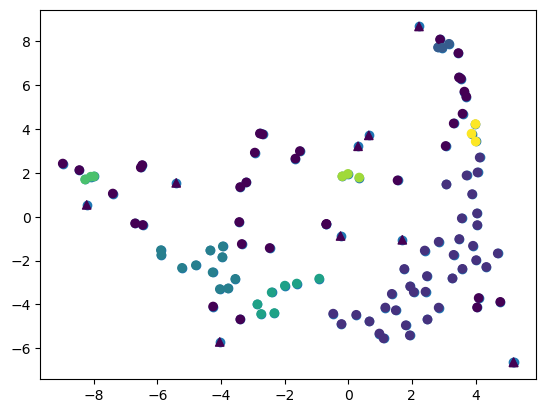

In [27]:
# Scale embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
#print(np.shape(embeddings_scaled))

# Visualize using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_scaled)
'''
print(np.shape(embeddings_2d))
print(np.shape(embeddings_2d[:, 0]))
print(np.shape(embeddings_2d[:, 1]))
print(embeddings_scaled)
print(embeddings_2d)
'''

vehicle_indices = list(gnn.train_vehicle_mapping.values())
tower_indices = list(gnn.train_tower_mapping.values())

vehicle_embeddings = embeddings[vehicle_indices]
tower_embeddings = embeddings[tower_indices]

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
#plt.scatter(embeddings_2d[:len(vehicle_indices), 0], embeddings_2d[:len(vehicle_indices), 1], c=vehicle_cluster_labels, cmap='viridis', marker='o', label='Vehicles')
#plt.scatter(embeddings_2d[len(vehicle_indices):, 0], embeddings_2d[len(vehicle_indices):, 1], c=tower_cluster_labels, cmap='viridis', marker='^', label='Towers')
#plt.show()

# Apply KMeans clustering
dbscan = DBSCAN(eps=1, min_samples=3).fit(embeddings_scaled)
labels = dbscan.labels_
#print (labels)
vehicle_cluster_labels = labels[:len(vehicle_indices)]
tower_cluster_labels = labels[len(vehicle_indices):]

# Visualize the clusters
#plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.scatter(embeddings_2d[:len(vehicle_indices), 0], embeddings_2d[:len(vehicle_indices), 1], c=vehicle_cluster_labels, cmap='viridis', marker='o', label='Vehicles')
plt.scatter(embeddings_2d[len(vehicle_indices):, 0], embeddings_2d[len(vehicle_indices):, 1], c=tower_cluster_labels, cmap='viridis', marker='^', label='Towers')
#plt.show()

Implementing some methods to process handovers

In [28]:
def select_best_tower(vehicle_id, cluster_towers):
    # Calculate cosine similarity between each vehicle and all towers

    vehicle_embedding = vehicle_embeddings[vehicle_id]
   
    best_tower = None
    best_similarity = np.inf  # Start with the worst possible value

    for tower in cluster_towers:
        tower_index = gnn.train_tower_mapping[tower]
        tower_embedding = tower_embeddings[tower_index - len(vehicle_indices)]  # Adjust index for towers

        # Calculate cosine similarity between vehicle and tower embeddings
        similarity = cosine_similarity([vehicle_embedding], [tower_embedding])[0][0]
        #print(tower)
        #similarity = euclidean_distances([vehicle_embedding], [tower_embedding])[0][0]

        if similarity < best_similarity:
            best_similarity = similarity
            best_tower = tower

    return best_tower

In [29]:
def make_handover_decision(vehicle_id, cluster_labels):
    #vehicle_cluster_labels = cluster_labels[:len(vehicle_indices)]
    vehicle_cluster_labels = cluster_labels[vehicle_id]
   
    #tower_cluster_labels = cluster_labels[len(vehicle_indices):]
   
    #vehicle_cluster = cluster_labels[vehicle_mapping[vehicle_id]]
    cluster_towers = [tower for tower, label in gnn.train_tower_mapping.items() if cluster_labels[label] == vehicle_cluster_labels]
    #cluster_towers = [tower for tower, label in tower_cluster_labels if cluster_labels[label] == vehicle_cluster_labels]
    if not cluster_towers:
        #raise ValueError(f"No towers found in the same cluster as vehicle {vehicle_id}")
        #print(f"No towers found in the same cluster as vehicle {vehicle_id}")
        best_tower = None
    else:
    # Calculate similarity or other criteria to select the best tower for handover
        
        #best_tower = select_best_tower(vehicle_id, cluster_towers, node_embeddings, tower_embeddings)
        best_tower = select_best_tower(vehicle_id, cluster_towers)
    return best_tower

In [30]:
edgeF = gnn.train_graph_data.edge_index.numpy()
edgeFF = gnn.test_graph_data.edge_index.numpy()  
pred = np.zeros((2,100), dtype=int)
index = 0
for vehicle, vehicle_id in gnn.train_vehicle_mapping.items():
    #print("yay")
    #print(vehicle)
    pred[0][index] = vehicle_id
    best_tower = make_handover_decision(vehicle_id, labels)
    if best_tower == None:
        best_tower = edgeF[1][vehicle_id] ##currentTower
        for tower, tower_id in gnn.train_tower_mapping.items():
            if tower_id == best_tower:
                best_tower = tower
                break
    for tower, tower_id in gnn.train_tower_mapping.items():
        if tower == best_tower:
            pred[1][index] = tower_id
            break  
    #print("pred= ", best_tower) 
    index = index + 1


getting accuracy of kmean cluster

In [31]:
# Calculate accuracy
true = edgeFF[:,:100] #future one
tureii = edgeF[:,:100] #old one
y_true = true[1,:]
y_truii = tureii[1,:]
y_pred = pred[1,:]
accuracy = accuracy_score(y_true, y_pred)
yoo = accuracy_score(y_truii, y_true)
acc = gnn.evaluate_model()
'''
print("Accuaracy before kmean cluster", acc)
print("Accuracy:", accuracy)  # Output: Accuracy: 0.8
print(yoo)
'''



'\nprint("Accuaracy before kmean cluster", acc)\nprint("Accuracy:", accuracy)  # Output: Accuracy: 0.8\nprint(yoo)\n'

Performance Analysis

In [32]:
ss = silhouette_score(embeddings_scaled, labels) 
#print("silhouette score: " ,ss)
dbs = davies_bouldin_score(embeddings_scaled, labels) 
#print("davies bouldin score: ",dbs)
accuracy = accuracy_score(y_true, y_pred)
#print("Accuaracy score", accuracy)
mse = mean_squared_error(y_true, y_pred)
#print("Mean Squared Error: ", mse)
chs = calinski_harabasz_score(embeddings_scaled, labels)
f1 = metrics.f1_score(y_true, y_pred, average='micro')
ps = metrics.precision_score(y_true, y_pred, average='micro')
rs = metrics.recall_score(y_true, y_pred, average='micro')
vm = metrics.v_measure_score(y_true, y_pred)


num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
cluster_center = np.zeros(num_clusters)
n_noise_ = list(labels).count(-1)
#print(num_clusters)
#print(n_noise_)
#print(labels)
#print(labels.size)
#print(cluseter_center)
for i in range(num_clusters):
    cluster_mask = labels == i
    #print(f"Cluster {i+1}: {np.sum(cluster_mask)} nodes")
    points_of_cluster_0 = embeddings_scaled[labels==0,:]
    centroid_of_cluster_0 = np.mean(points_of_cluster_0, axis=0) 
    #print(centroid_of_cluster_0)
    cluster_center[i] = np.mean(cluster_mask)
#print(dbscan.core_sample_indices_)
#print(cluster_center)

node_intra_distances = np.zeros(num_clusters)
for cluster in range(num_clusters):
    cluster_mask = labels == cluster
    cluster_distances = np.linalg.norm(embeddings_scaled[cluster_mask] - cluster_center[cluster], axis=1)
    node_intra_distances[cluster] = np.mean(cluster_distances)
node_avg_intra_distances = np.mean(node_intra_distances)
#print(node_avg_intra_distances)

node_inter_distances = np.zeros(num_clusters)
for cluster in range(num_clusters):
    other_clusters_centers = np.delete(cluster_center, cluster, axis=0)
    cluster_distances = np.linalg.norm(other_clusters_centers - cluster_center[cluster])
    node_inter_distances[cluster] = np.mean(cluster_distances)
node_avg_inter_distances = np.mean(node_inter_distances)
#print(node_avg_inter_distances)

dist = node_avg_inter_distances/node_avg_intra_distances

'''
print("Calinski Harabasz Score: ", chs)
print(metrics.cohen_kappa_score(y_true, y_pred))
print(metrics.f1_score(y_true, y_pred, average='micro'))
print(metrics.hamming_loss(y_true, y_pred))
print(metrics.jaccard_score(y_true, y_pred, average="micro"))
print(metrics.matthews_corrcoef(y_true, y_pred))
#print(metrics.multilabel_confusion_matrix(y_true, y_pred))
print(metrics.precision_score(y_true, y_pred, average='micro'))
print(metrics.recall_score(y_true, y_pred, average='micro'))
print(metrics.r2_score(y_true, y_pred))
print(metrics.completeness_score(y_true, y_pred))
print(metrics.mutual_info_score(y_true, y_pred))
print(metrics.rand_score(y_true, y_pred))
print(metrics.v_measure_score(y_true, y_pred))
dists = metrics.pairwise.euclidean_distances(kmeans.cluster_centers_)
print(dists)
tri_dists = dists[np.triu_indices(5, 1)]
print(tri_dists)
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
print(max_dist)
print(avg_dist)
print(min_dist)
max_dist, avg_dist, min_dist = dists.max(), dists.mean(), dists.min()
print(max_dist)
print(avg_dist)
print(min_dist)
'''

'\nprint("Calinski Harabasz Score: ", chs)\nprint(metrics.cohen_kappa_score(y_true, y_pred))\nprint(metrics.f1_score(y_true, y_pred, average=\'micro\'))\nprint(metrics.hamming_loss(y_true, y_pred))\nprint(metrics.jaccard_score(y_true, y_pred, average="micro"))\nprint(metrics.matthews_corrcoef(y_true, y_pred))\n#print(metrics.multilabel_confusion_matrix(y_true, y_pred))\nprint(metrics.precision_score(y_true, y_pred, average=\'micro\'))\nprint(metrics.recall_score(y_true, y_pred, average=\'micro\'))\nprint(metrics.r2_score(y_true, y_pred))\nprint(metrics.completeness_score(y_true, y_pred))\nprint(metrics.mutual_info_score(y_true, y_pred))\nprint(metrics.rand_score(y_true, y_pred))\nprint(metrics.v_measure_score(y_true, y_pred))\ndists = metrics.pairwise.euclidean_distances(kmeans.cluster_centers_)\nprint(dists)\ntri_dists = dists[np.triu_indices(5, 1)]\nprint(tri_dists)\nmax_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()\nprint(max_dist)\nprint(avg_dist)\np